# Dynamic Time Warping (DTW)

The following offers a demonstration of the capabalities of the DTW module within darts. Dynamic Time Warping allows you to compare two time series of different lengths and time axes. The algorithm will determine the optimal alignment between elements in the two series, such that the pair-wise distance between them is minimized.

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from darts.dataprocessing import dtw
from darts.utils import timeseries_generation as tg
from darts.utils.missing_values import fill_missing_values
from darts.datasets import SunspotsDataset
from darts.timeseries import TimeSeries
from darts.metrics import dtw_metric, mae, mape
from darts.models import MovingAverageFilter
from scipy.signal import argrelextrema
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
SMALL_SIZE = 30
MEDIUM_SIZE = 35
BIGGER_SIZE = 40
FIG_WIDTH = 20
FIG_SIZE = (40, 10)


plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=FIG_SIZE)  # size of the figure

## Read and Format

Here we simply read the CSV file containing the number of sunspots, and transform the values into the desired format. 
We resample the dateset to eliminate high-frequency noise, as we are only interested in the general shape.

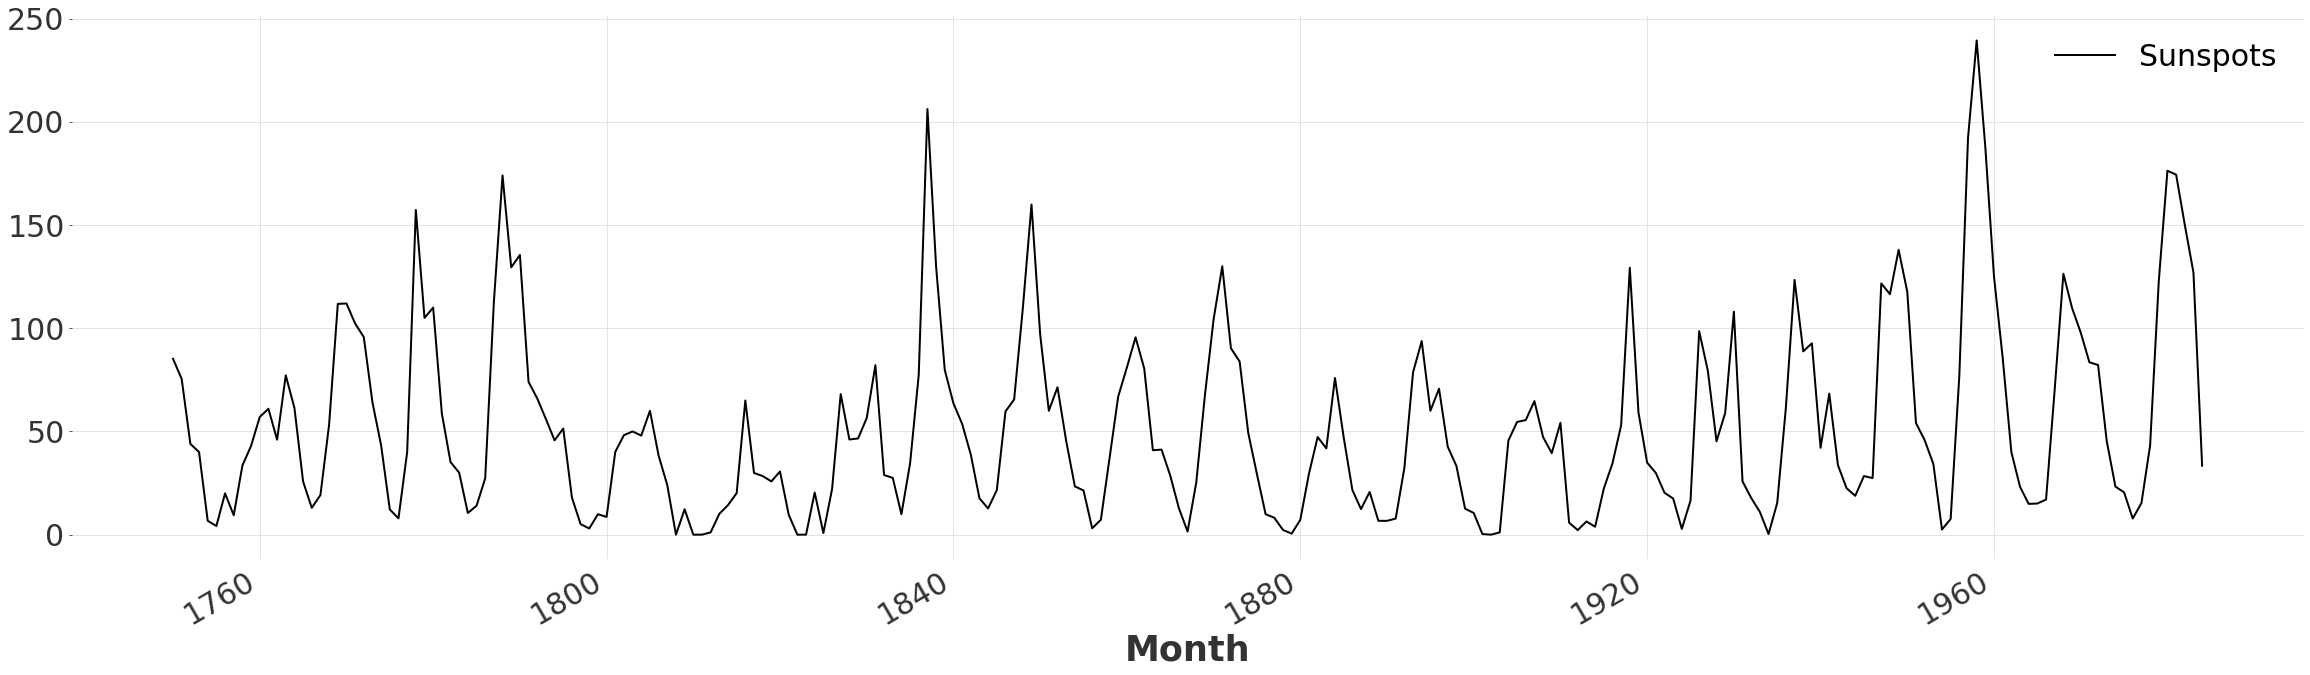

In [4]:
ts = SunspotsDataset().load()
ts = ts.resample(freq="y")
ts.plot()

## Determine the Number of Peaks

We observe that the series is composed of a series of sharp peaks and troughs. Let's quickly determine the number of periods to consider. We begin by applying a moving average filter to the series, to eliminate false local maxima.
Then we simply count the number of local maxima returned by `argrelextrema`.

In [5]:
ts_smooth = MovingAverageFilter(window=3).filter(ts)

minimums = argrelextrema(ts_smooth.univariate_values(), np.greater)

periods = len(minimums[0])
periods

24

## Generate a Pattern to Compare With

Here we simply construct a simplified pattern based on the previous observation, of linear peaks and troughs. We ensure that the mean is 0 and range is 1, to make it easier to fit to the data.

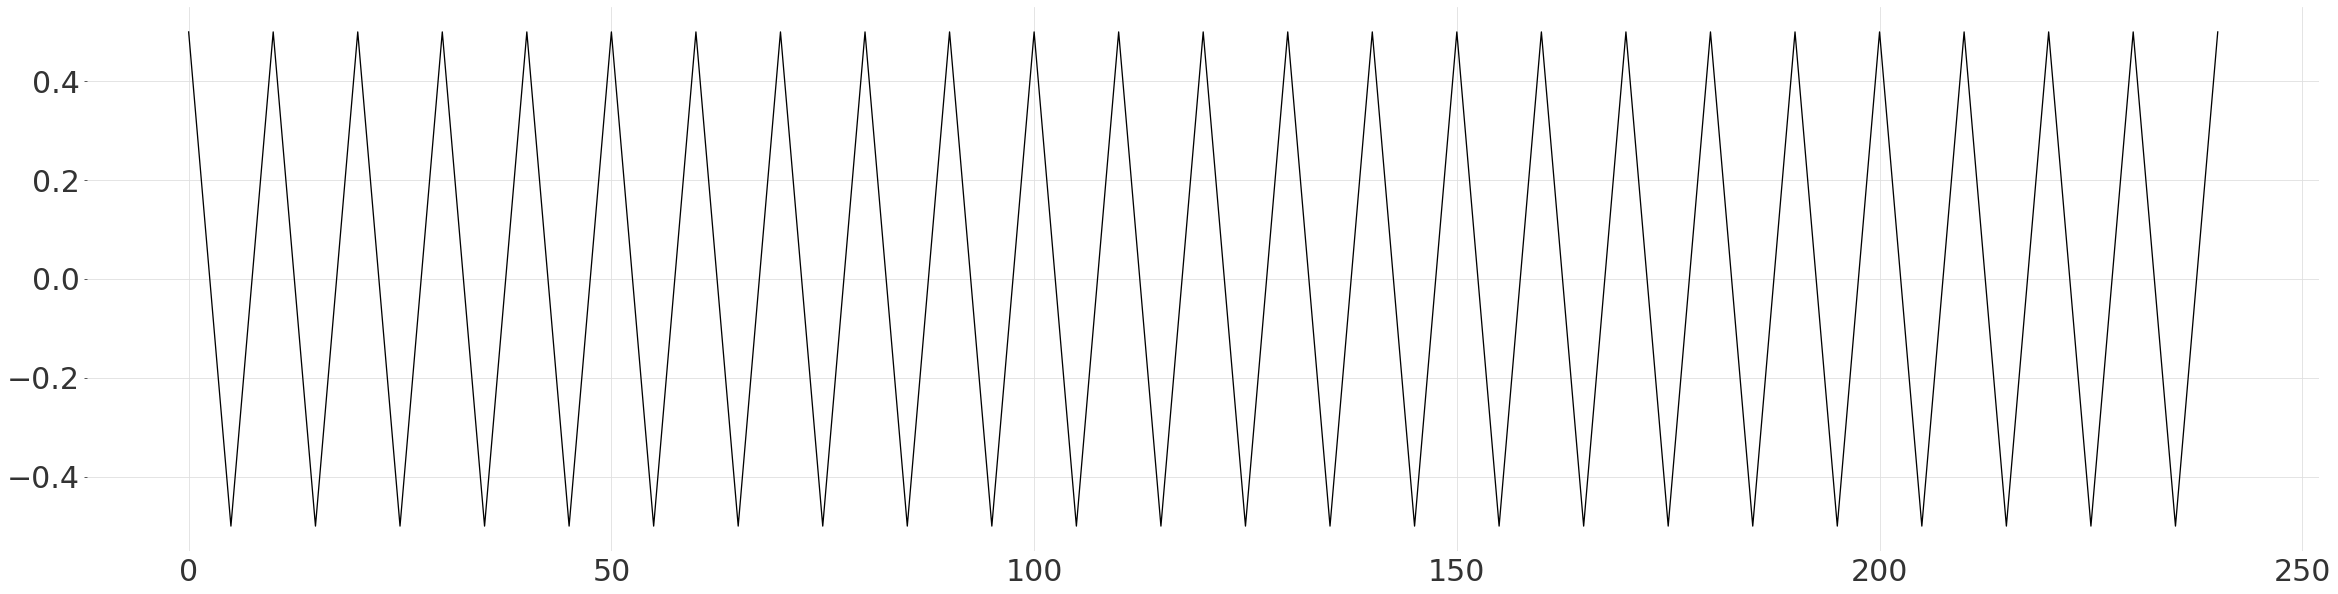

In [6]:
steps = int(np.ceil(len(ts) / (periods * 2)))
down = np.linspace(0.5, -0.5, steps + 1)[:-1]
up = np.linspace(-0.5, 0.5, steps + 1)[:-1]

values = np.append(np.tile(np.append(down, up), periods), 0.5)

plt.plot(np.arange(len(values)), values)

## Fit the Pattern to the Series

We rescale and shift the data to be inline with the actual series. Then we create a new `TimeSeries`, with the same time axis as the Sunspot dataset. While this is not necessary to perform Dynamic Time Warping, it will enable us to plot and compare the initial alignment. Since our pattern is slightly longer than the Sunspot time series itself, we drop all values past the end date. 

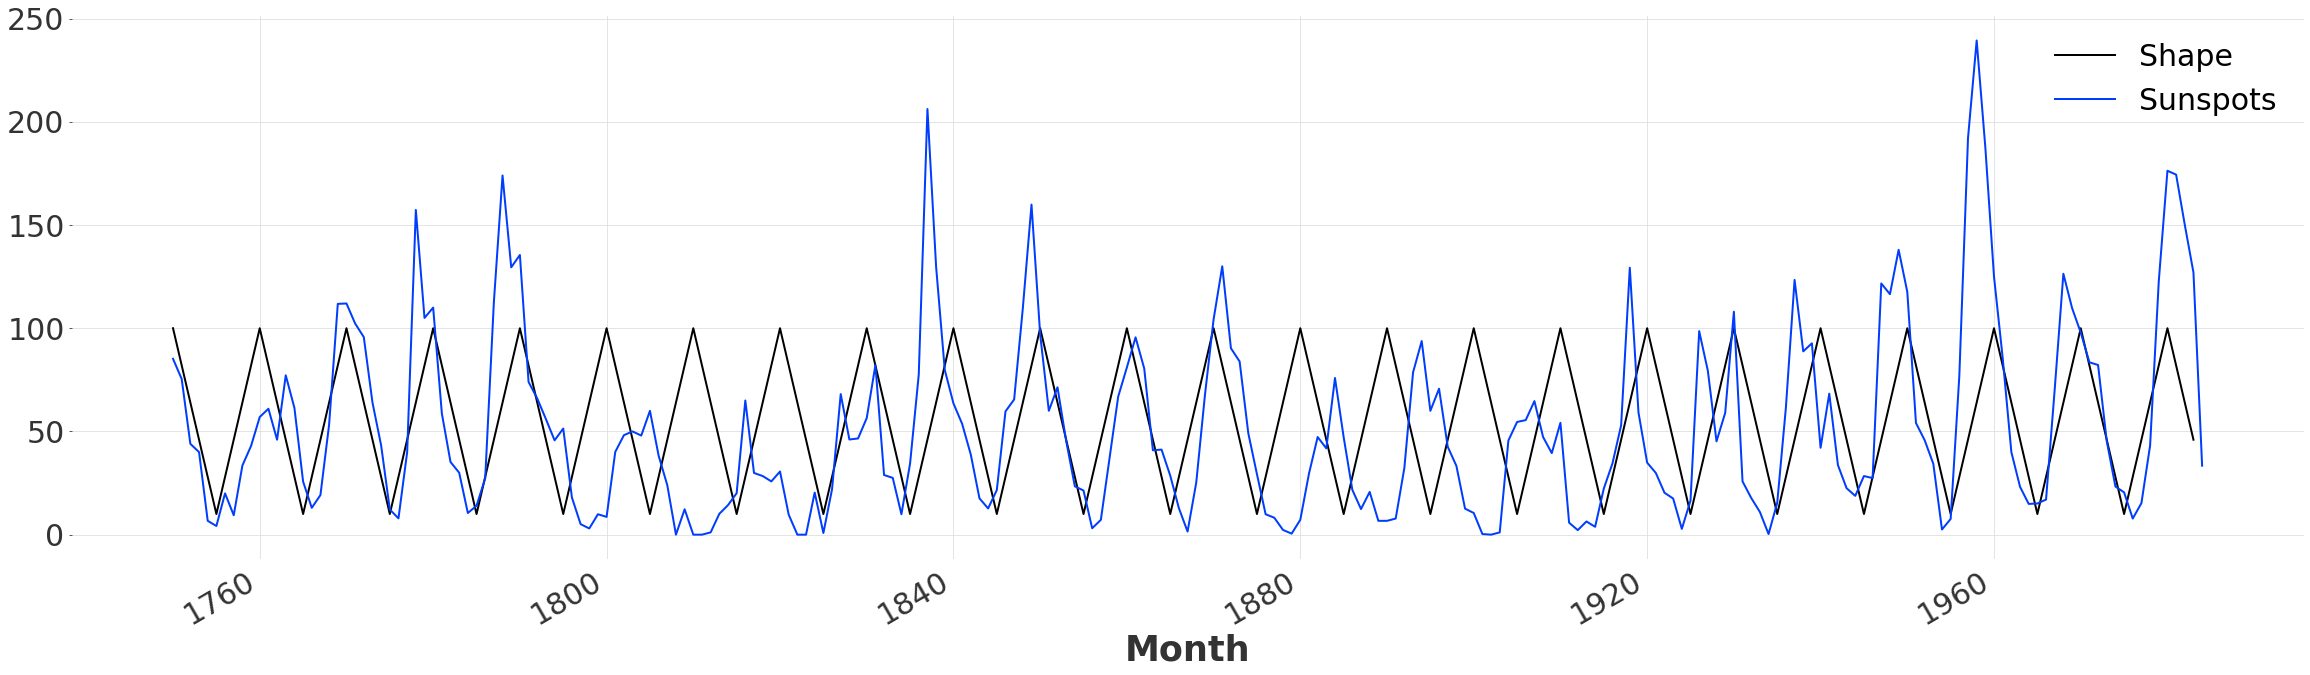

In [7]:
m = 90
c = 55

scaled_values = values * m + c

time_range = pd.date_range(start=ts.start_time(), freq="y", periods=len(values))
ts_shape_series = pd.Series(scaled_values, index=time_range, name="Shape")

ts_shape = TimeSeries.from_series(ts_shape_series)
ts_shape = ts_shape.drop_after(ts.end_time())
ts_shape.plot()
ts.plot()

## Quantitative Comparison

We can use MEAN ABSOLUTE ERROR also known as `mae`, to evaluate how closely our simple pattern fits the data. Looking at the plot above it is clear that that there is some fluctuation in the time between peaks, leading to a misalignment and a relatively high error.

In [8]:
original_mae = mae(ts, ts_shape)
original_mae

34.01837606837607

## Enter Dynamic Time Warping

Fortunately finding the optimal alignment between two series is exactly what DTW was designed for! All we have to do is call the dtw with two time series.

### No Window

The default behaviour is to consider all possible alignments between the time series. This becomes obvious when we plot the cost matrix, together with the path using `.plot()`. The cost matrix indicates the total cost/distance of the alignment that would match (i,j) together. For our timeseries we observe a dark green band passing through the diagonal. This indicates that the two time series are mostly aligned to begin with.

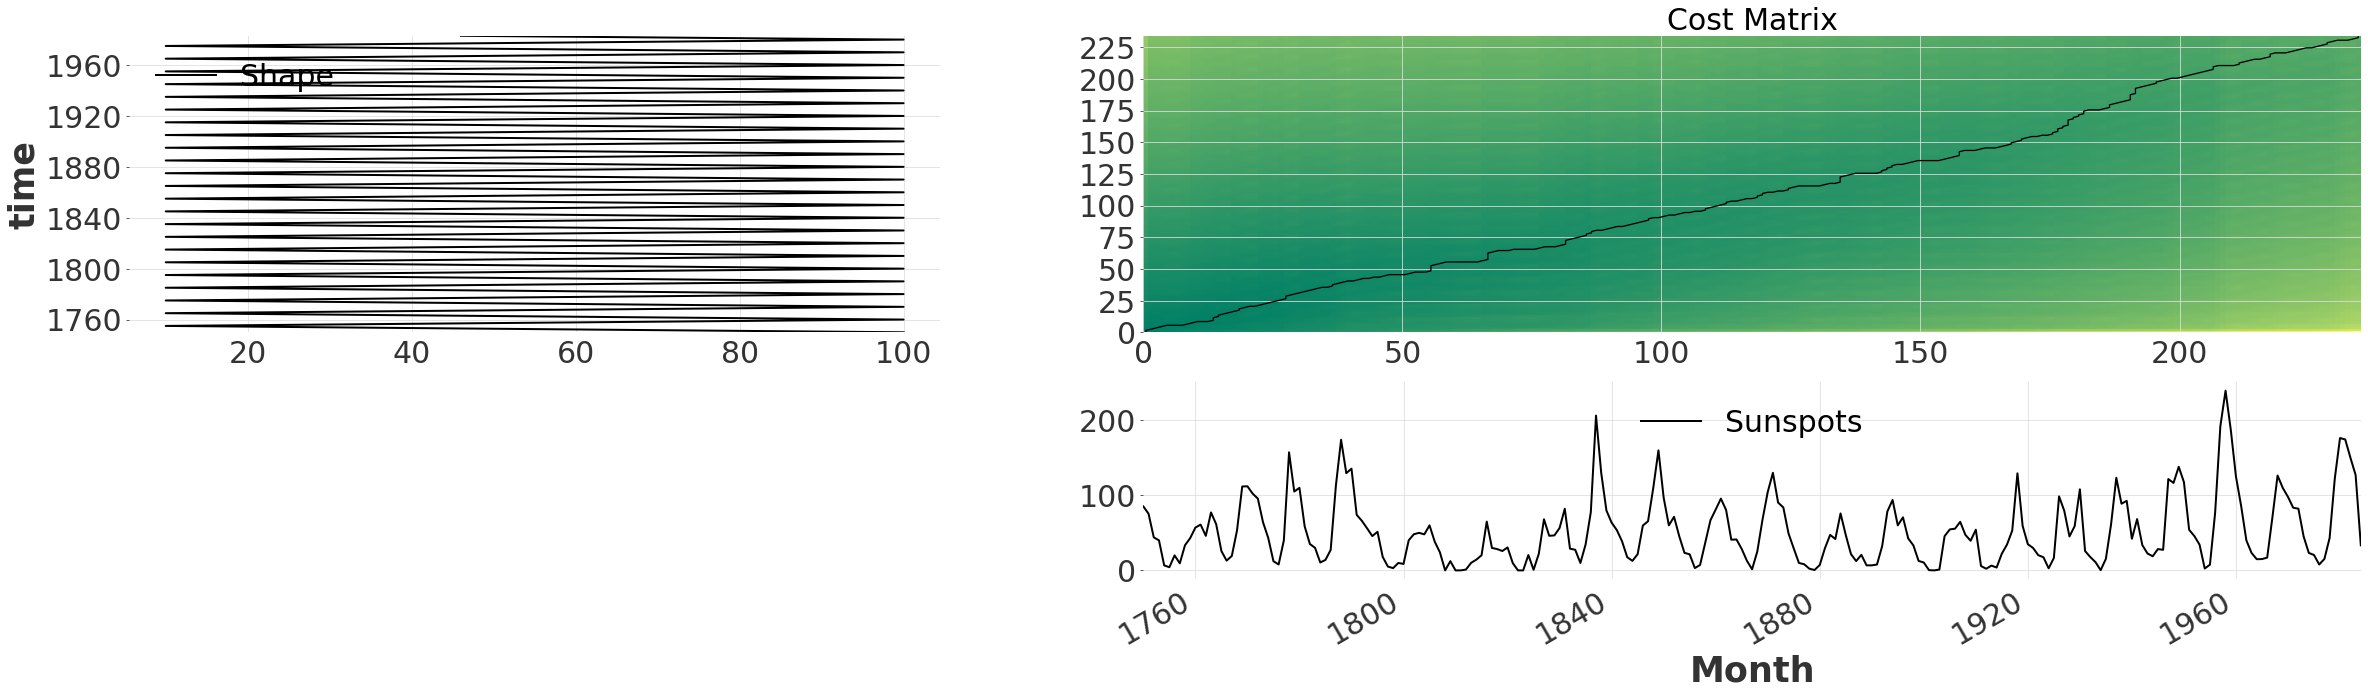

In [9]:
exact_alignment = dtw.dtw(ts, ts_shape)
exact_alignment.plot(show_series=True)

## Multi-Grid

Computing all possible alignment quickly becomes computationally expensive on large datasets (quadratic complexity). 

Instead we can use the multi grid solver, which runs in near linear-time. The solver determines the optimal path first on a smaller grid, and then recursively reprojects and refines the path, each time doubling the resolution. Simply enabling the multi-grid solver (linear complexity) will usually result in a large speed-up, without much loss of accuracy.

The parameter `multi_grid_radius` controls how much to extend the search window by from the path found at a lower resolution. In other words, you gain accuracy at the cost of performance by increasing it.

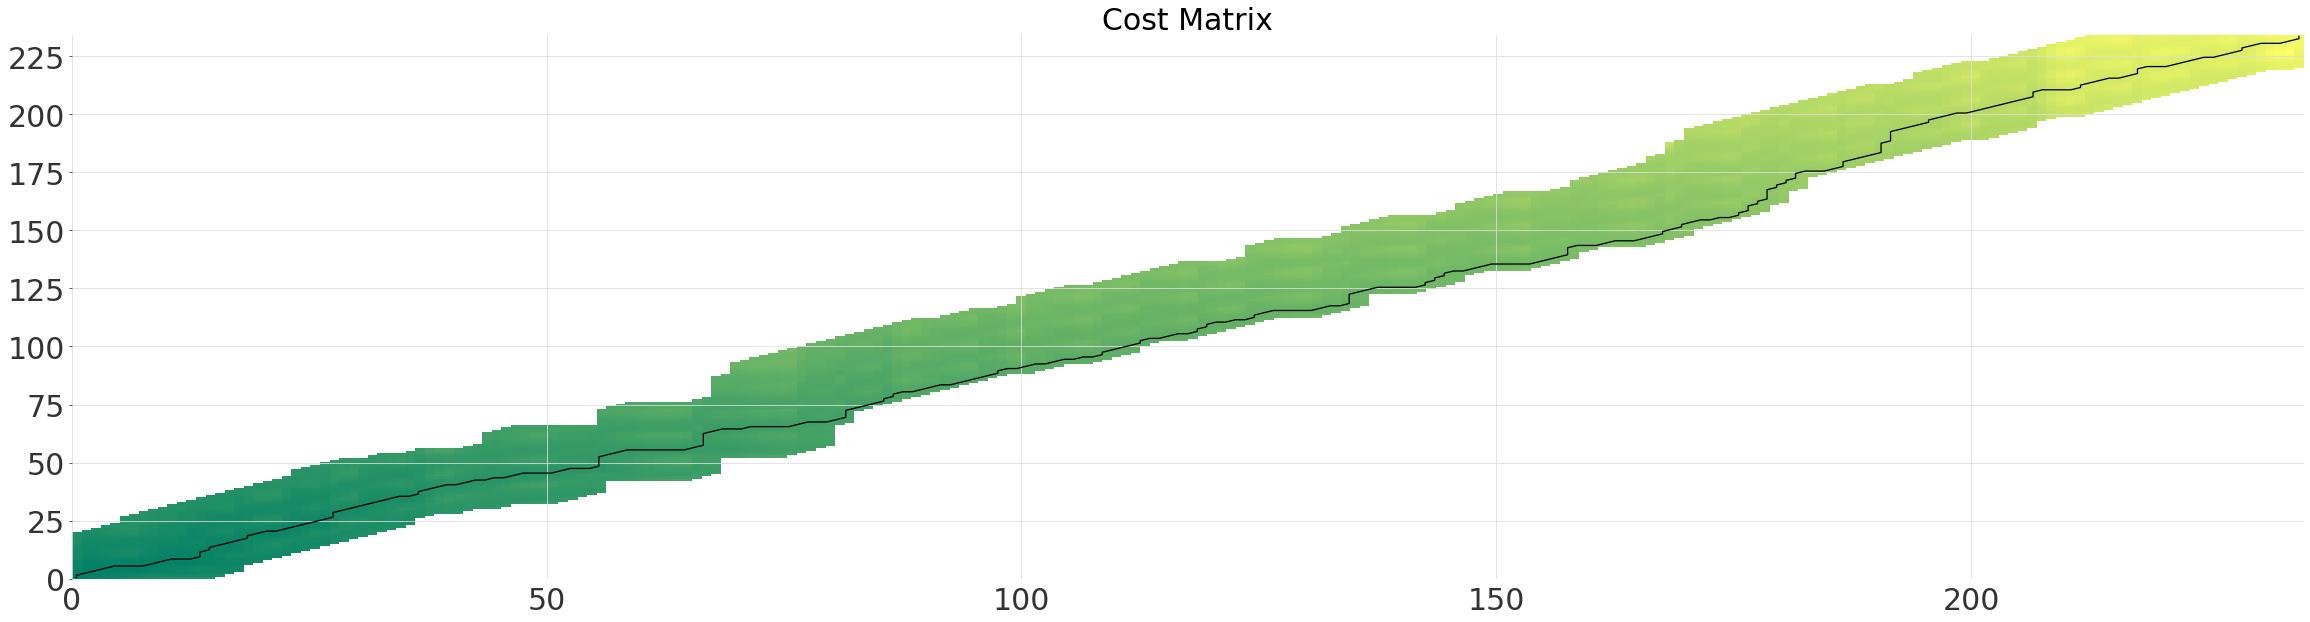

In [10]:
multi_grid_radius = 10

multigrid_alignment = dtw.dtw(ts, ts_shape, multi_grid_radius=multi_grid_radius)
multigrid_alignment.plot()

## Diagonal Window (SakoeChiba)

The SakoeChiba window forms a diagonal band, determined by the `window_size` parameter. The window is best applied when you know that the two time series are already mostly aligned or want to constrain the amount of warping. It will ensure that element n in one series, is only every matched with element n-window_size in the other.

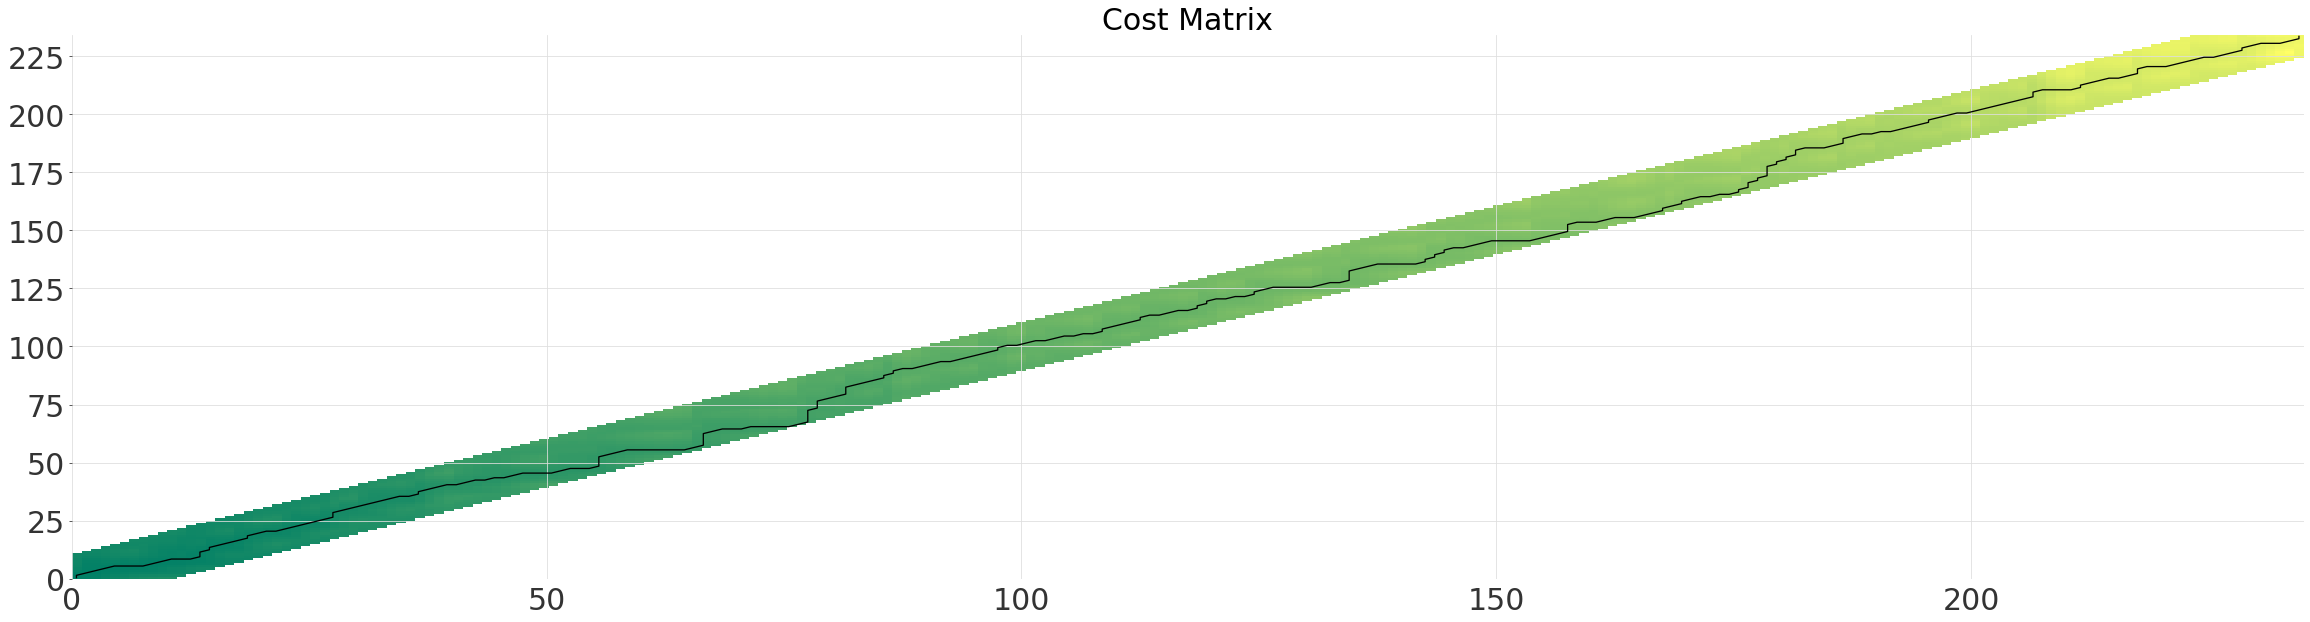

In [11]:
sakoechiba_alignment = dtw.dtw(ts, ts_shape, window=dtw.SakoeChiba(window_size=10))
sakoechiba_alignment.plot()

## Parallelogram Window (Itakura)

The parameter `max_slope` controls the gradient of the steeper side of the parallelogram. For our time-series the window is somewhat wastefull as the optimal path does not deviate significantly from the diagonal. 

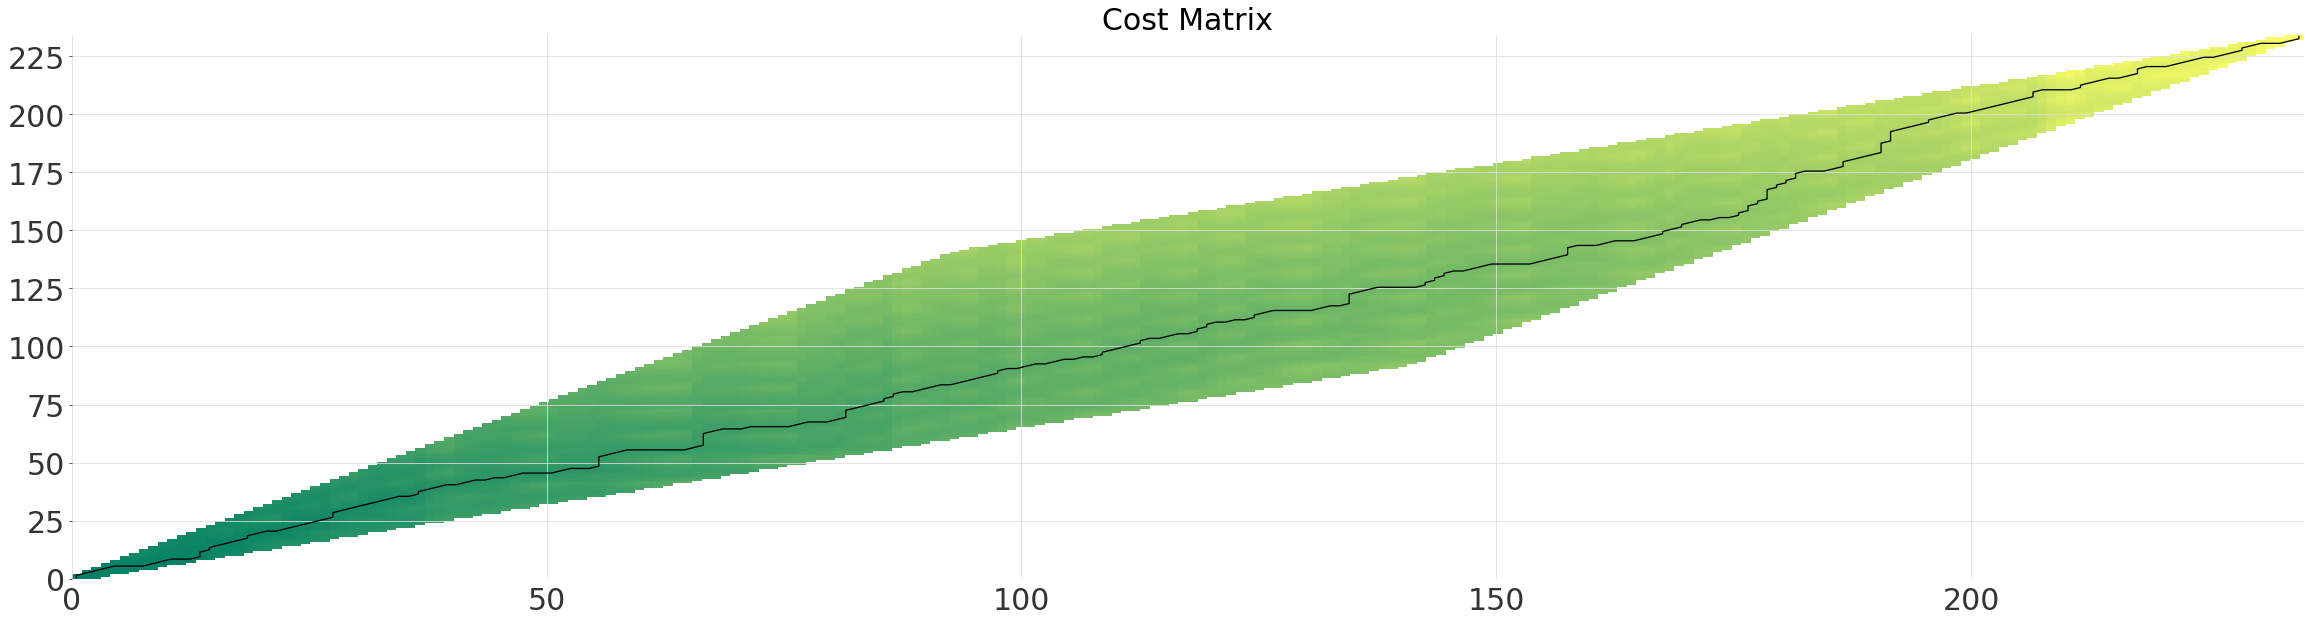

In [12]:
itakura_alignment = dtw.dtw(ts, ts_shape, window=dtw.Itakura(max_slope=1.5))
itakura_alignment.plot()

## Comparison of the Different Alignments

Though each of the windows will have resulted in different runtimes, the length of the paths are effectively identical. Were we to constrain the windows further or reduce the multi_grid_radius, we would find the optimal path  to be a shorter than the rest.

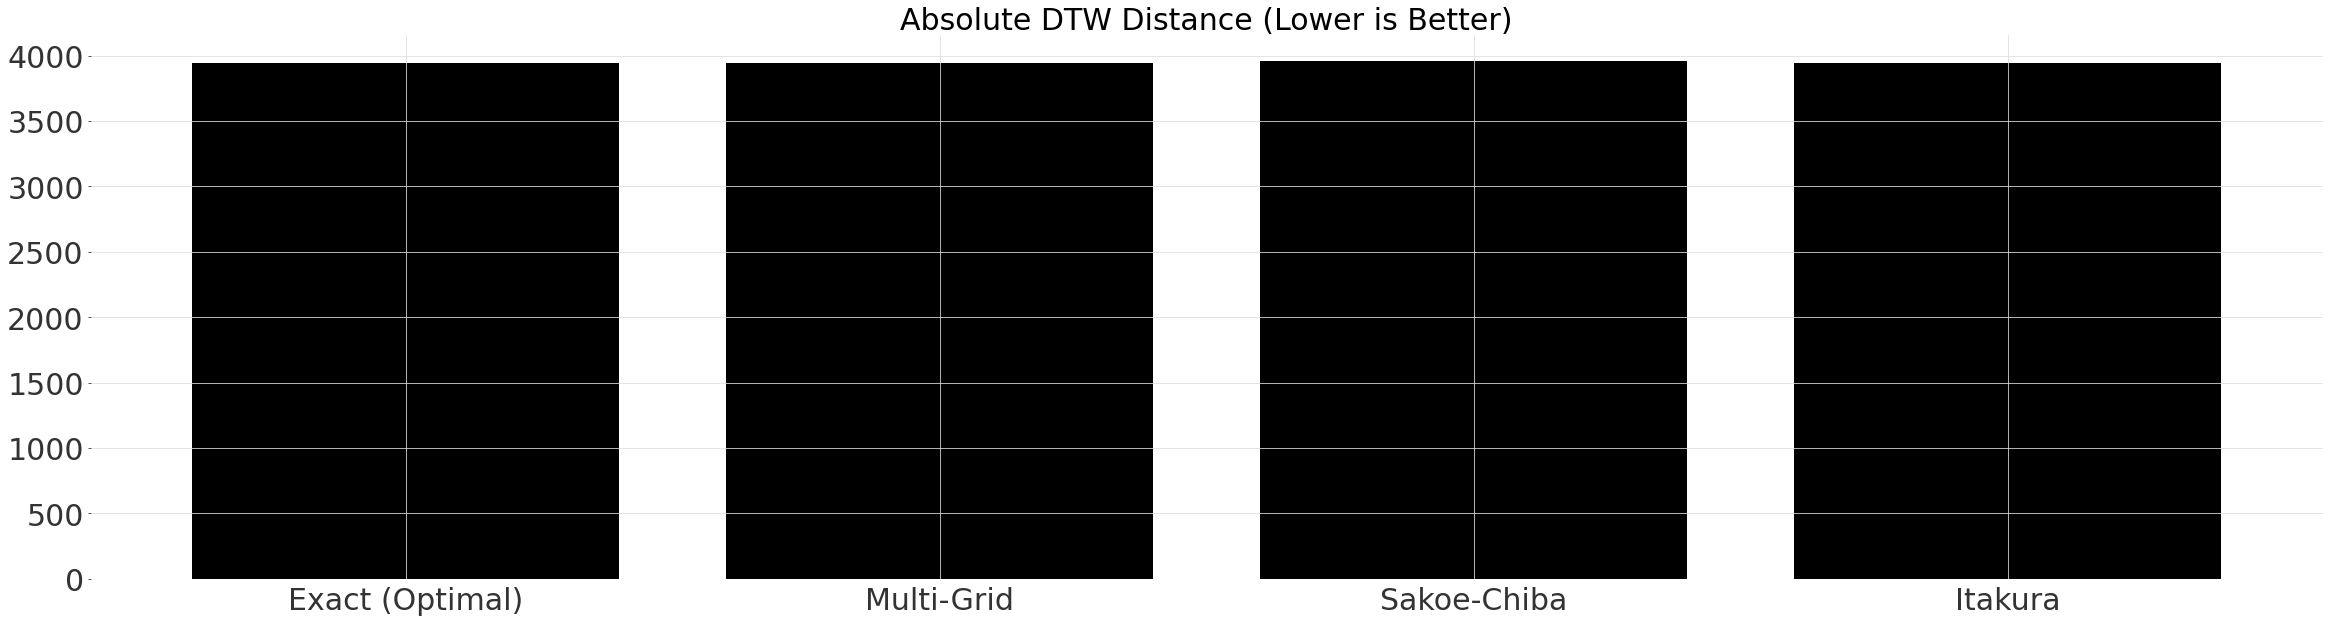

In [13]:
alignments = [
    exact_alignment,
    multigrid_alignment,
    sakoechiba_alignment,
    itakura_alignment,
]
names = ["Exact (Optimal)", "Multi-Grid", "Sakoe-Chiba", "Itakura"]
distances = [align.distance() for align in alignments]

plt.title("Absolute DTW Distance (Lower is Better)")
plt.bar(names, distances)

alignment = multigrid_alignment

## Visualizing the Alignment

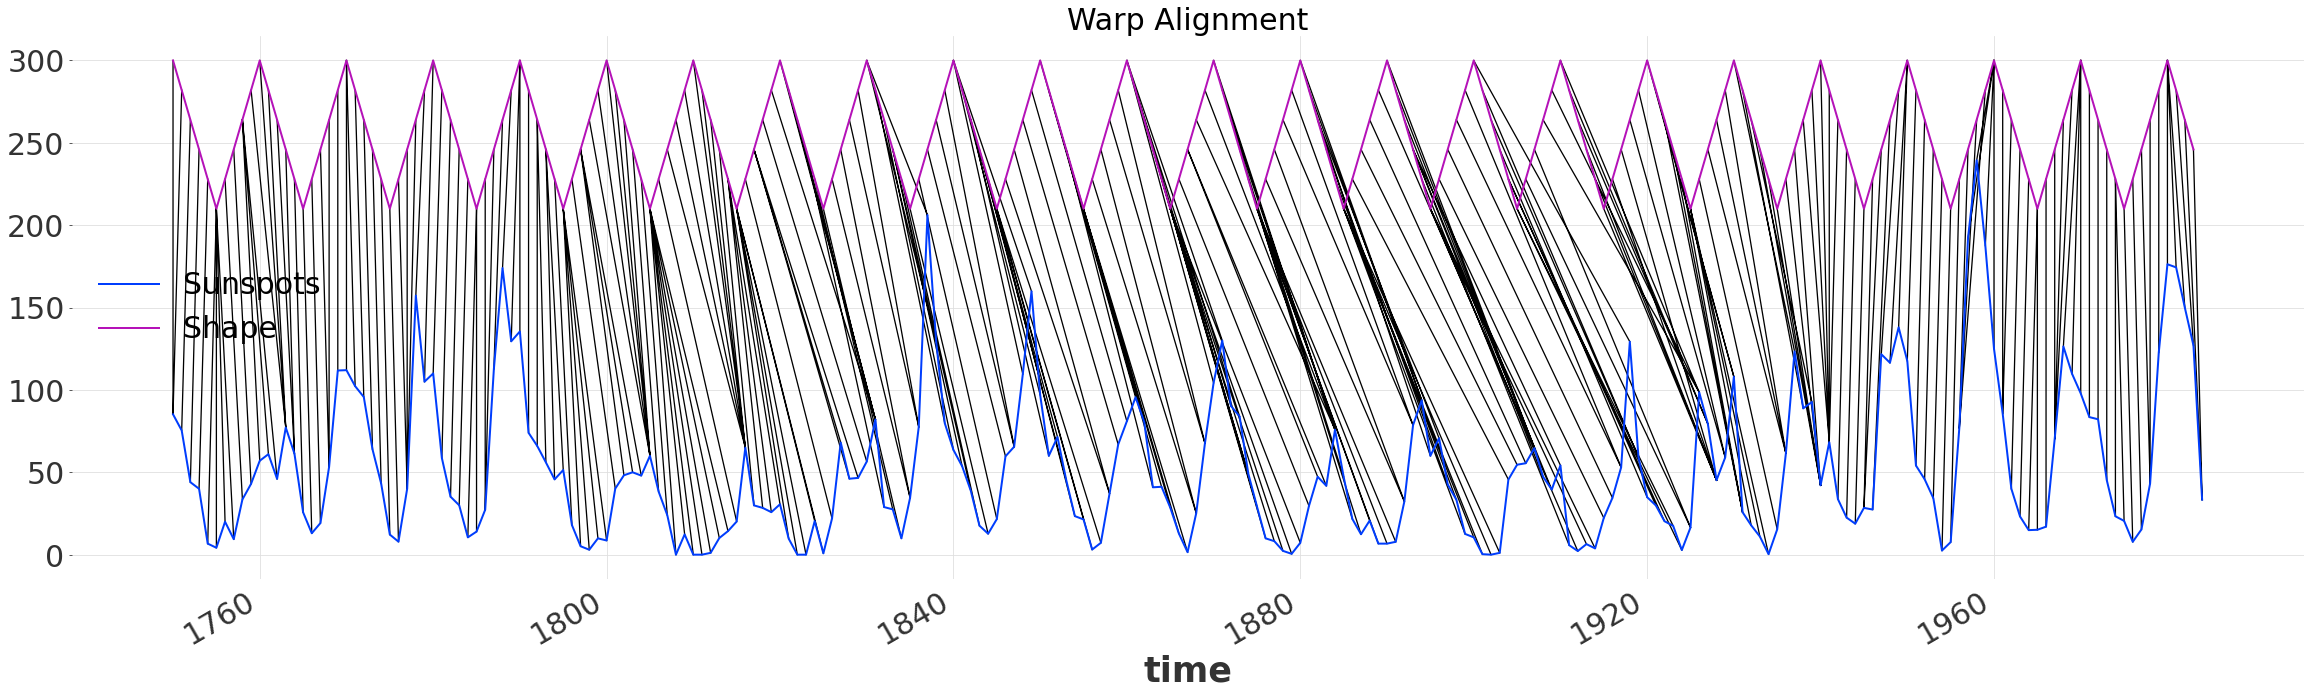

In [14]:
alignment.plot_alignment(series2_y_offset=200)
plt.gca().set_title("Warp Alignment")

### Warped Time Series

Once we have found an aligment, we can produce two warped series, of the same length. Since we've warped the time dimension, by default the new warped series are indexed by `pd.RangeIndex`. Now our simple pattern matches up with the series, despite them not doing so originally!

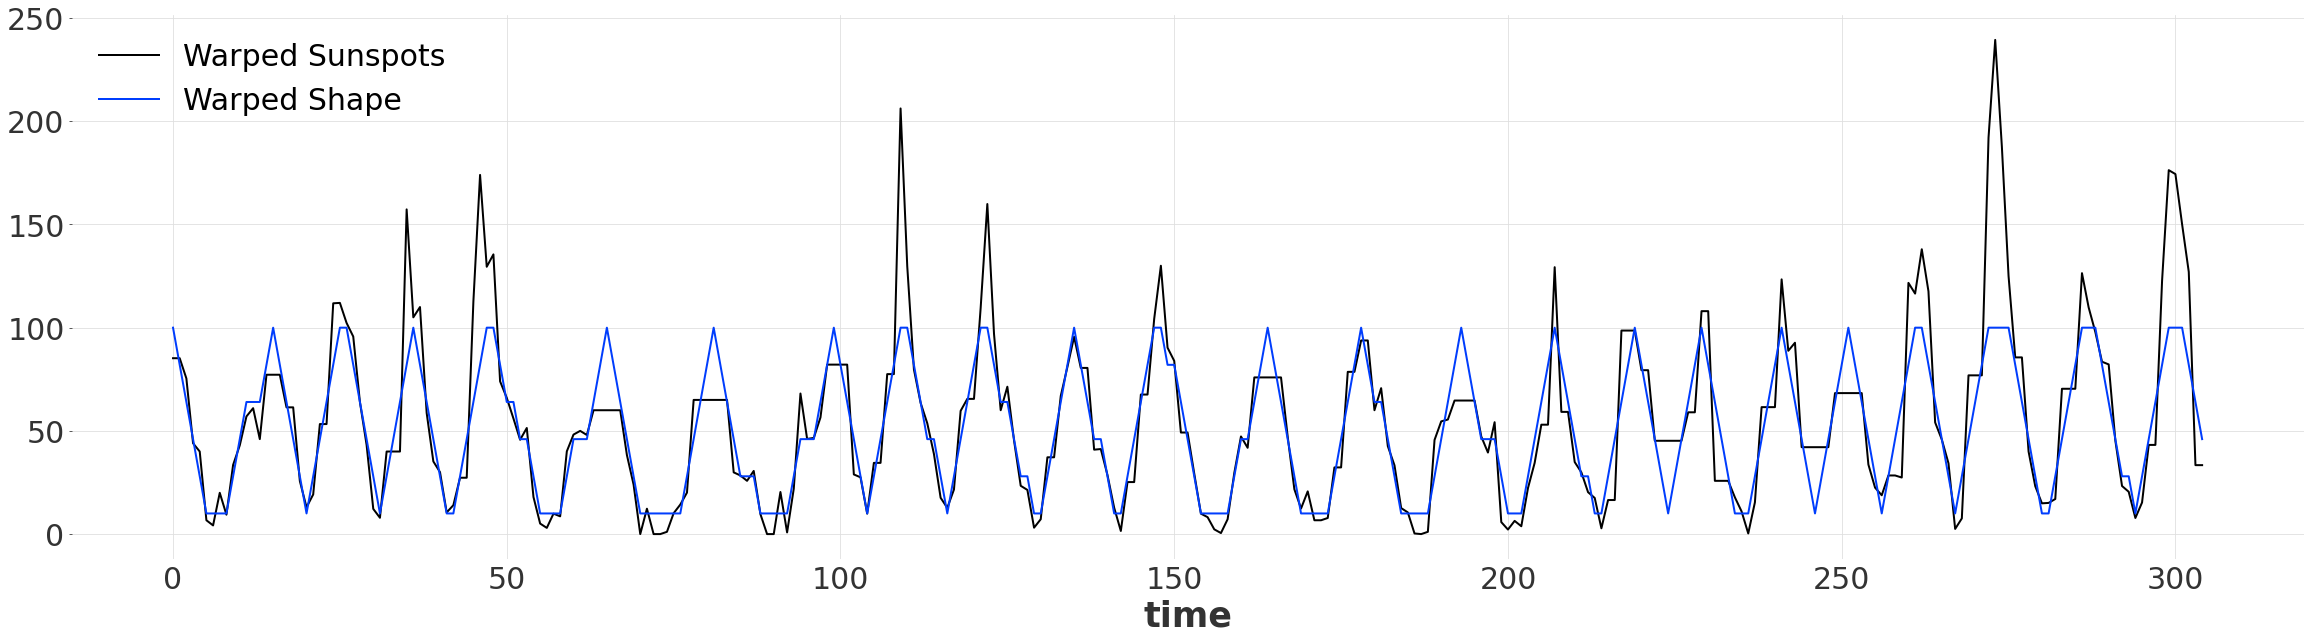

In [15]:
warped_ts, warped_ts_shape = alignment.warped()

warped_ts.plot(label="Warped Sunspots")
warped_ts_shape.plot(label="Warped Shape")

## Quantitative Comparison

We can again apply the `mae` metric, however this time to our warped series. If we were interested only in the similarity after warping, we could also just have called the helper function `dtw_metric`. Notice the ~65% reduction in the error between the warped series!

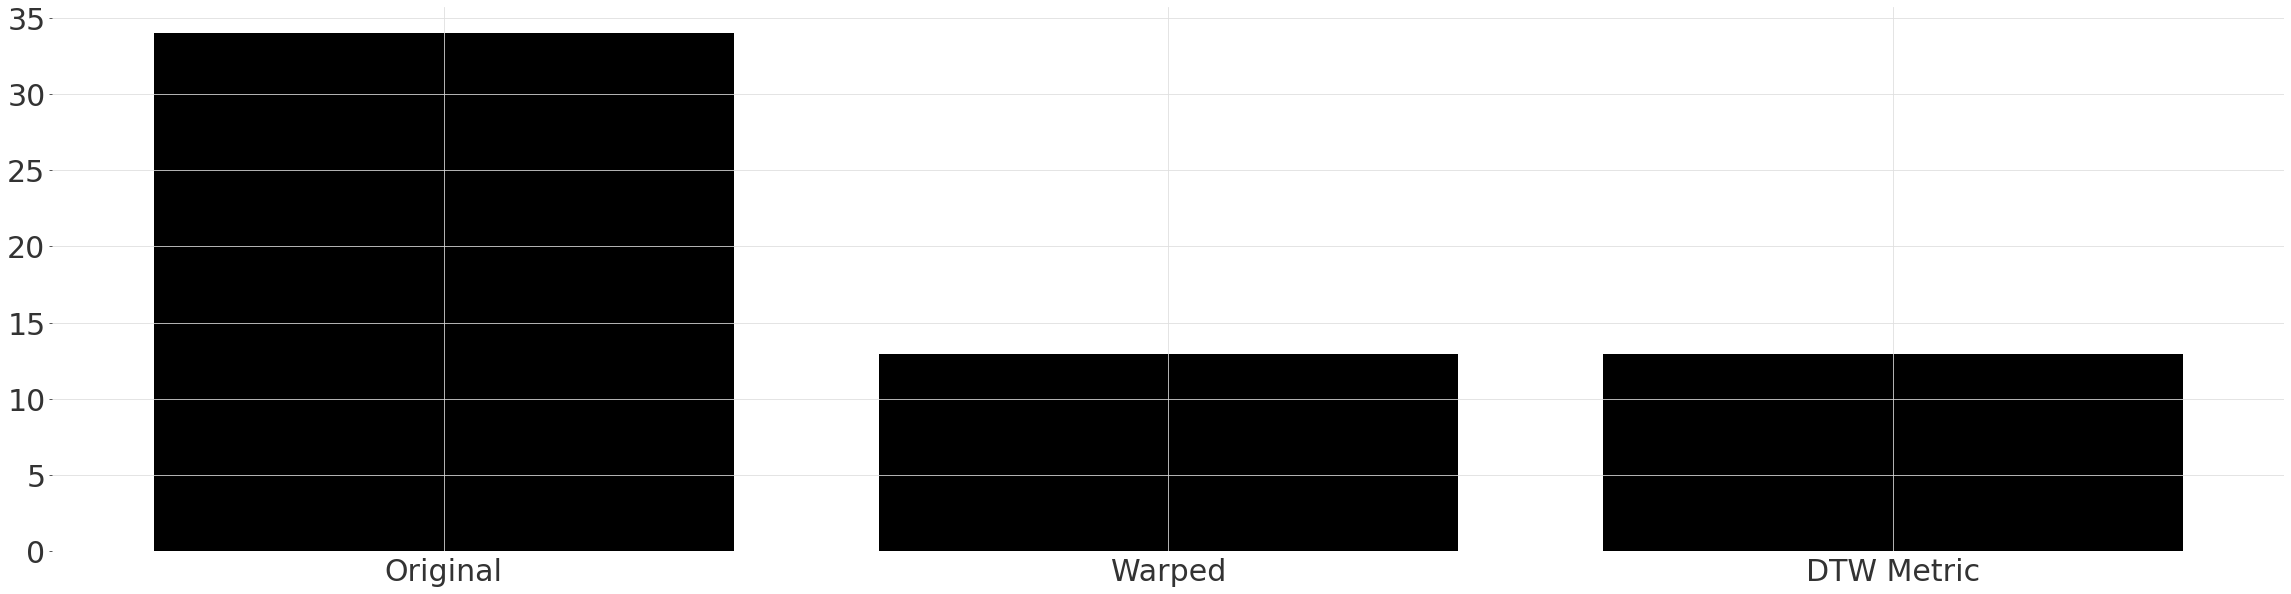

In [16]:
warped_mae0 = mae(warped_ts, warped_ts_shape)
warped_mae1 = dtw_metric(ts, ts_shape, metric=mae, multi_grid_radius=multi_grid_radius)

plt.bar(["Original", "Warped", "DTW Metric"], [original_mae, warped_mae0, warped_mae1])

## Finding Matching Subsequences

Given the alignment we can find matching subsequences of the two time series.

1. The difference between two elements is smaller than some threshold
2. The original pattern was not distorted
3. The subsequence has some minimum length

In [17]:
THRESHOLD = 20
MATCH_MIN_LENGTH = 5

path = alignment.path()
path = path.reshape((-1,))

warped_ts_values = warped_ts.univariate_values()
warped_ts_shape_values = warped_ts_shape.univariate_values()

within_threshold = (
    np.abs(warped_ts_values - warped_ts_shape_values) < THRESHOLD
)  # Criterion 1
linear_match = np.diff(path[1::2]) == 1  # Criterion 2

matches = np.logical_and(within_threshold, np.append(True, linear_match))
if not matches[-1]:
    matches = np.append(matches, False)

matched_ranges = []
match_begin = 0

last_m = False
for i, m in enumerate(matches):
    if last_m and not m:
        match_end = i - 1
        match_len = match_end - match_begin

        if match_len >= MATCH_MIN_LENGTH:  # Criterion 3
            matched_ranges.append(pd.RangeIndex(match_begin, i - 1))
    if not last_m and m:
        match_begin = i
    last_m = m

matched_ranges

[RangeIndex(start=0, stop=5, step=1),
 RangeIndex(start=16, stop=23, step=1),
 RangeIndex(start=27, stop=33, step=1),
 RangeIndex(start=97, stop=108, step=1),
 RangeIndex(start=115, stop=121, step=1),
 RangeIndex(start=131, stop=138, step=1),
 RangeIndex(start=174, stop=180, step=1),
 RangeIndex(start=218, stop=223, step=1),
 RangeIndex(start=252, stop=258, step=1)]

## Visualizing the Matching Subsequences

We can simply slice the warped shape series by the RangeIndex to extract the subsequence. 

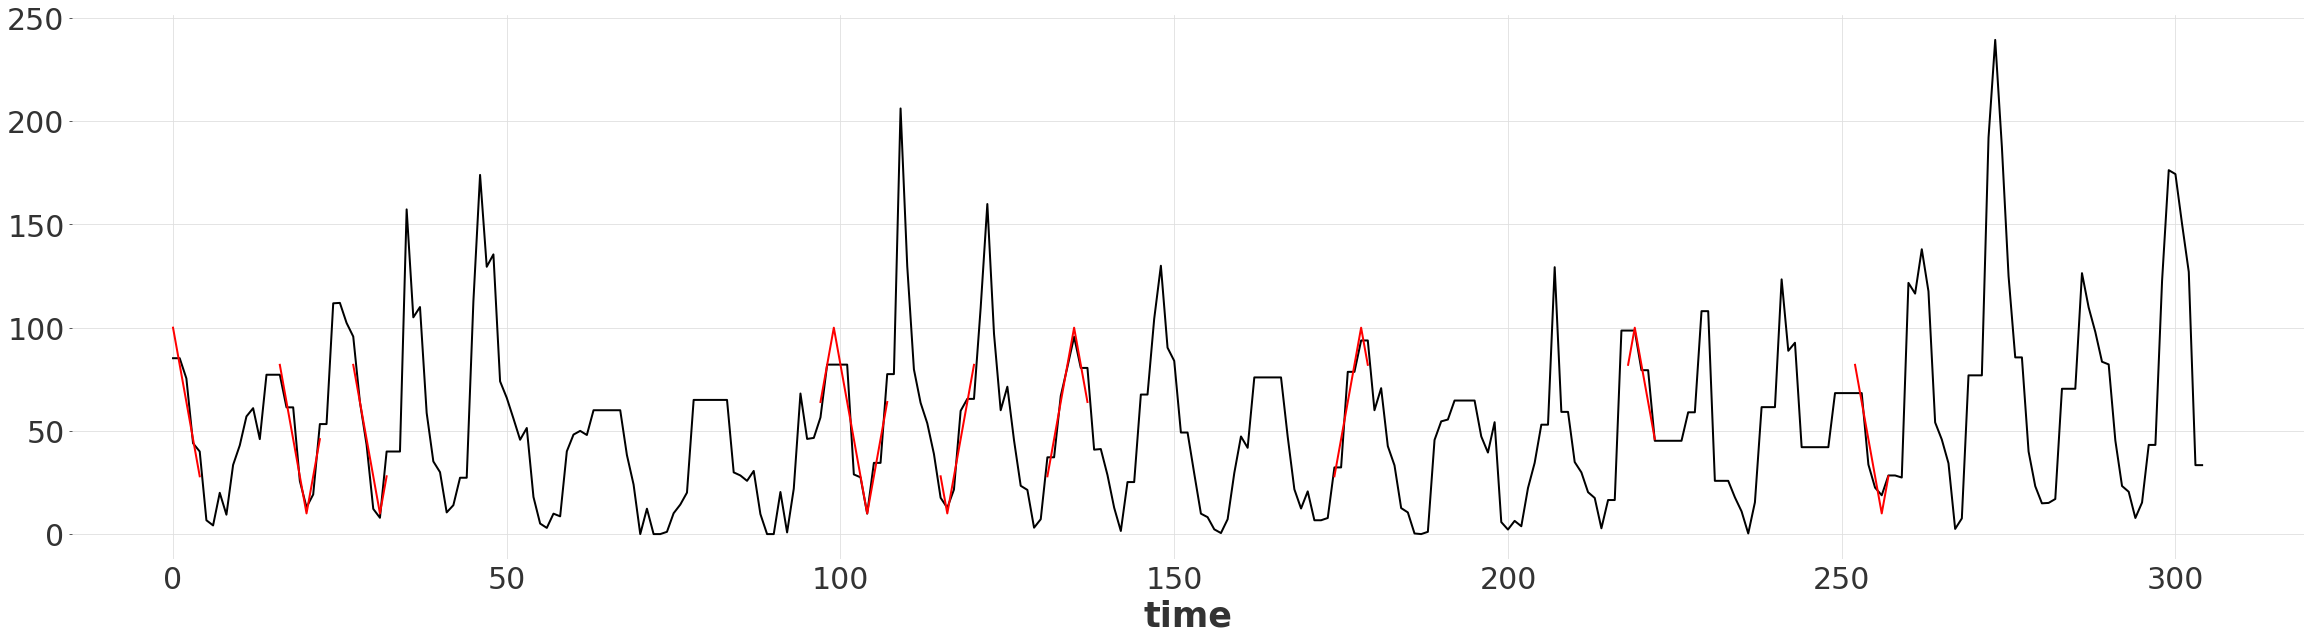

In [18]:
warped_ts.plot()

for r in matched_ranges:
    warped_ts_shape[r].plot(color="red")

plt.gca().get_legend().remove()